In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
import astropy.units as u
from astropy.modeling.models import custom_model
from specutils.fitting import fit_lines
from scipy import interpolate
import keras
from orcs.process import SpectralCube
from scipy.optimize import Bounds
from numdifftools import Jacobian, Hessian


In [5]:
# Read in Data

sigma_info = []
velocity_info = []
res_info = []
spectrum = fits.open('../Data/Spectrum_0.fits')
header = spectrum[0].header
spec = spectrum[1].data
channel = []
counts = []
for chan in spec:
    channel.append(chan[0])
    counts.append(chan[1])

axis = channel
sky = counts
velocity = header['VELOCITY']
sigma = header['BROADEN']
print(velocity, sigma)

-30.85659995987419 60.00431869007818


In [8]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('../ML/Reference-Spectrum-R5000.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

In [9]:
f = interpolate.interp1d(axis, sky, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale
print(sky_corr.shape)

(460,)


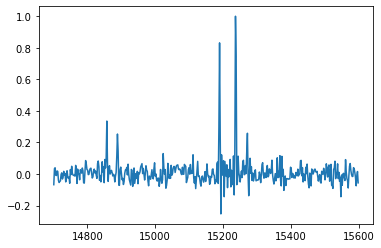

In [10]:
plt.plot(wavenumbers_syn, sky_corr)

In [11]:
model = keras.models.load_model('../ML/R5000-PREDICTOR-I')

Spectrum = sky_corr.reshape(1, sky_corr.shape[0], 1)
print(Spectrum.shape)
predictions = model(Spectrum, training=False)
vel_ml = float(predictions[0][0])
broad_ml = float(predictions[0][1])
print(vel_ml, broad_ml)
line_halpha = 656.28
line_ml = 1e7/((vel_ml/3e5)*line_halpha + line_halpha)
print(line_ml)
# Calculate flux estimate
line_ind = np.argmin(np.abs(np.array(axis)-line_ml))
flux_est = np.max([sky[line_ind-1], sky[line_ind], sky[line_ind+1]])
print(flux_est)

(1, 460, 1)
-31.73664093017578 22.62379264831543
15239.010788010537
1.0


In [12]:
A_min = 0#1e-19
A_max = 1.#1e-15
x_min = 14700
x_max = 15400
sigma_min = 0
sigma_max = 10

class Gaussian:
    def __init__(self, channel, params):
        A = params[0]; x = params[1]; sigma = params[2]
        self.func = A*np.exp((-(channel-x)**2)/(2*sigma**2))

# Update the model
def gaussian_model(channel, theta, models):
    """
    """
    f1 = 0.0
    for model_num in range(len(models)):
        params = theta[model_num*3:(model_num+1)*3]
        f1 += Gaussian(channel, params).func
    return f1


In [13]:
def log_likelihood(theta, x, y, yerr, model):
    """
    theta - list of parameters for gaussian fit
    """
    #if model == 1:
    #    A_,B_,x_,sigma_ = theta
    #    model = gaussian_model(x, A_, B_, x_, sigma_)
    #elif model == 2:
    #    A_,B_,x_,sigma_, A2_, x2_, sigma2_ = theta
    #    model = gaussian_model2(x, A_, B_, x_, sigma_, A2_, x2_, sigma2_)
    model = gaussian_model(x, theta, model)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))


In [25]:
line_dict = {'Halpha': 656.280, 'NII6583': 658.341, 'NII6548': 654.803, 'SII6716': 671.647, 'SII6731': 673.085}
def line_vals_estimate(spec, line_name):
    line_theo = line_dict[line_name]
    line_pos_est = 1e7/((vel_ml/3e5)*line_theo + line_theo)  # Estimate of position of line in cm-1
    line_ind = np.argmin(np.abs(np.array(axis)-line_pos_est))
    line_amp_est = np.max([sky[line_ind-2], sky[line_ind-1], sky[line_ind], sky[line_ind+1], sky[line_ind+2]])
    line_broad_est = (line_pos_est*2.355*broad_ml)/3e5
    return line_amp_est, line_pos_est, line_broad_est
    
model = ['Halpha', 'NII6583', 'NII6548', 'SII6716', 'SII6731']
nll = lambda *args: -log_likelihood(*args)
initial = np.ones((3*len(model)))
sky_scale = np.max(sky)
sky_norm = sky/sky_scale
bounds_ = []#np.zeros((3*len(model), 2))
#print(bounds)
#bounds = Bounds([0, -0.5], [1.0, 2.0])
for mod in range(len(model)):
    val = 3*mod + 1
    amp_est, vel_est, sigma_est = line_vals_estimate(sky_norm, model[mod])
    initial[3*mod] = amp_est
    initial[3*mod + 1] = vel_est
    initial[3*mod + 2] = sigma_est
    bounds_.append((A_min, A_max))
    bounds_.append((x_min, x_max))
    bounds_.append((sigma_min, sigma_max))
bounds_l = [val[0] for val in bounds_]
bounds_u = [val[1] for val in bounds_]
bounds = Bounds(bounds_l, bounds_u)
print(initial)
cons = ({'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[1]-line_dict['Halpha'])/(1e7/x[1]))},
        {'type': 'eq', 'fun': lambda x: x[2] - x[5]},
        {'type': 'eq', 'fun': lambda x: x[5] - x[8]},
        {'type': 'eq', 'fun': lambda x: x[5] - x[11]},
        {'type': 'eq', 'fun': lambda x: x[5] - x[14]},
        {'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[7]-line_dict['NII6548'])/(1e7/x[7]))},
        {'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[10]-line_dict['SII6716'])/(1e7/x[10]))},
        {'type': 'eq', 'fun': lambda x: 3e5*((1e7/x[4]-line_dict['NII6583'])/(1e7/x[4])) - 3e5*((1e7/x[13]-line_dict['SII6731'])/(1e7/x[13]))})

def fun_der(theta, axis, y, yerr, model):
    return Jacobian(lambda theta: log_likelihood(theta, axis, y, yerr, model))(theta).ravel()

soln = minimize(nll, initial, method='SLSQP',# jac=fun_der,
                options={'disp': True}, bounds=bounds, tol=1e-8,
                args=(axis, sky_norm, 1e-2, model), constraints=cons)
init_var = soln.x
line_fit = 1e7/((init_var[1]/3e5)*line_halpha + line_halpha)
print(init_var)
print(3e5*((1e7/init_var[1] - 656.28)/(1e7/init_var[1])))
print(3e5*init_var[2]/init_var[1])
#print(3e5*((1e7/init_var[4] - line_dict['NII6583'])/(1e7/init_var[4])))
#print(init_var[2], init_var[5], init_var[8])
#print(3e5*((1e7/init_var[1]-656.28)/(1e7/init_var[1])))
#for i in range(len(model)):
#    init_var[i] = init_var[i]/sky_scale

[1.00000000e+00 1.52390108e+04 2.70639913e+00 6.21896625e-01
 1.51913036e+04 2.69792649e+00 2.08471254e-01 1.52733845e+04
 2.71250379e+00 2.11431623e-01 1.48903487e+04 2.64447786e+00
 2.57890016e-01 1.48585364e+04 2.63882811e+00]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14634.5703125
            Iterations: 2
            Function evaluations: 32
            Gradient evaluations: 2
[1.00000000e+00 1.52390108e+04 2.68002708e+00 6.21896625e-01
 1.51913036e+04 2.68002708e+00 2.08471254e-01 1.52733845e+04
 2.68002708e+00 2.11431623e-01 1.48903487e+04 2.68002708e+00
 2.57890016e-01 1.48585364e+04 2.68002708e+00]
-31.739998666646002
52.759863078379574


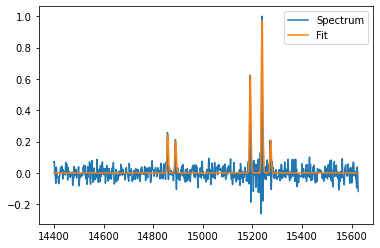

Calculated velocity: -31.74 km/s


In [26]:
#if model == 1:
parameters = soln.x
#for i in range(len(model)):
#    parameters[i*3] *= sky_corr_scale
#print(parameters)
#if model == 2:
    #parameters = [mean_[0], mean_[1],  mean_[2], mean_[3], mean_[4], mean_[5]]
final_model = gaussian_model(axis, parameters, model)
plt.clf()
plt.plot(axis, sky, label='Spectrum')
plt.plot(axis, final_model, label='Fit')
plt.legend()
plt.show()
l_calc = 1e7/parameters[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)

In [16]:
def log_prior(theta, model):
    for model_num in range(len(model)):
        params = theta[model_num*3:(model_num+1)*3]
    within_bounds = True  # Boolean to determine if parameters are within bounds
    for ct, param in enumerate(params):
        if ct%3 == 0:  # Amplitude parameter
            if param > A_min and param < A_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 1:  # velocity parameter
            if param > x_min and param < x_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 2:  # sigma parameter
            if param > sigma_min and param < sigma_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
    if within_bounds:
        return 0.0
    else:
        return -np.inf
    #A_,x_,sigma_ = theta
    #if A_min < A_ < A_max and x_min < x_ < x_max and sigma_min < sigma_ < sigma_max:
    #    return 0.0#np.log(1/((t_max-t_min)*(rp_max-rp_min)*(b_max-b_min)))
    #return -np.inf



In [17]:
def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)

In [18]:
n_dim = 3 * len(model)
n_walkers = n_dim * 2 + 4

init_ = init_var + 1 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(axis, sky_norm, 1e-2, model))
sampler.run_mcmc(init_, 500, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/home/carterrhea/anaconda3/envs/orb3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [00:03<00:00, 131.69it/s]


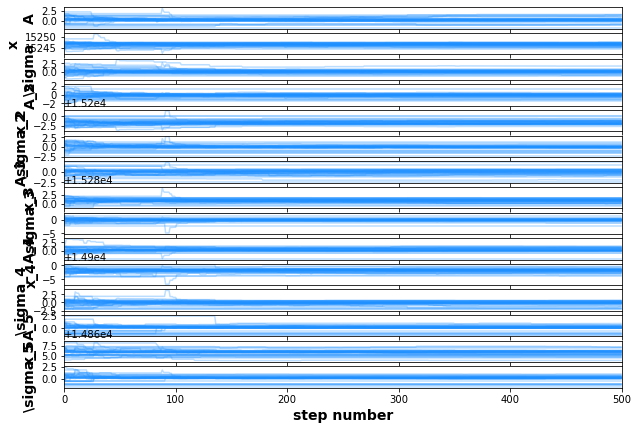

In [19]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
if len(model) == 1:
    labels = [r"A", r"x", "sigma"]
elif len(model) == 2:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2"]
elif len(model) == 3:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3"]
elif len(model) == 4:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3", r"A_4", r"x_4", r"\sigma_4"]
elif len(model) == 5:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2", r"A_3", r"x_3", r"\sigma_3", r"A_4", r"x_4", r"\sigma_4", r"A_5", r"x_5", r"\sigma_5"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", color='dodgerblue', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontweight='bold', fontsize=14)
    #ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number", fontsize=14, fontweight='bold');
plt.savefig('Emcee-steps.png')

In [20]:
flat_samples = sampler.get_chain(discard=200, flat=True)
parameters = []
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
#import corner
#fig = corner.corner(
#    flat_samples, labels=labels, color='dodgerblue', label_kwargs=dict(fontweight='bold', fontsize=14), fill_contours=True#, truths=[m_true, b_true, np.log(f_true)]
#);
#plt.plot()
#plt.savefig('Emcee-Corner.png')

[0.14325612723462142, 15246.57383941667, 0.02651805146985273, -0.18656893012824824, 15198.278408338007, -0.04236433122609817, -0.005718833142926594, 15280.868650507633, 0.032178813684632296, 0.18603231482473725, 14898.19925590159, -0.20018682932292098, 0.12893865872134078, 14865.894487180518, 0.21856865495912028]


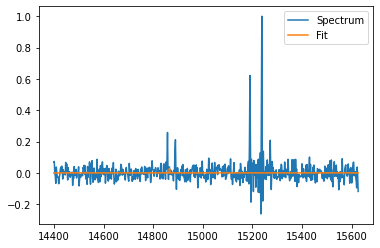

In [22]:
#if model == 1:
print(parameters)
#if model == 2:
    #parameters = [mean_[0], mean_[1],  mean_[2], mean_[3], mean_[4], mean_[5]]
final_model = gaussian_model(axis, parameters, model)
plt.clf()
plt.plot(axis, sky_norm, label='Spectrum')
plt.plot(axis, final_model, label='Fit')
plt.legend()

In [23]:
l_calc = 1e7/parameters[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)

Calculated velocity: -180.64 km/s


In [24]:
parameters[2]*3e5/(parameters[1])

0.5217838135141444